In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sainikhileshreddy/food-recognition-2022")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/food-recognition-2022


In [1]:
!pip install "deeplake<4"
!pip install hub

In [ ]:
# Replace 'username/dataset_name' with your dataset path
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(path) ]
print(onlyfiles)
print(listdir(path + '/hub'))

['raw_data', 'visualize_dataset.png', 'hub']
['val', 'test', 'train']


/usr/local/lib/python3.11/dist-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (4.2.10) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [ ]:
import os
import shutil

In [4]:
source_path = path + '/hub/train/'
destination_path = '/content/drive/MyDrive/food_recognition_dataset/' # Or any desired path in your Colab environment

In [ ]:
# Create the destination directory if it doesn't exist
os.makedirs(destination_path, exist_ok=True)

# Copy the contents of the source to the destination
shutil.copytree(source_path, destination_path, dirs_exist_ok=True)

'/content/drive/MyDrive/food_recognition_dataset/'

In [5]:
import hub

# Load the dataset from the copied location
ds = hub.dataset(destination_path)

/usr/local/lib/python3.11/dist-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (4.2.10) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(
/

/content/drive/MyDrive/food_recognition_dataset/ loaded successfully.



In [ ]:
print(ds)

Dataset(path='/content/food_recognition_dataset/', tensors=['images', 'images_meta', 'masks', 'boxes', 'categories', 'super_categories', 'areas', 'iscrowds'])


In [6]:
# Assuming 'labels' is the tensor with class labels
labels_tensor = ds['categories']

# Get unique class IDs by converting the tensor to a list of numpy arrays and then finding unique values
# Use aslist=True because the tensor has a dynamic shape
labels_list = labels_tensor.numpy(aslist=True)

# Flatten the list of arrays and find unique values
import numpy as np
all_labels = np.concatenate(labels_list)
unique_class_ids = np.unique(all_labels)

print("Unique class IDs:", unique_class_ids)

# If your dataset has a tensor with class names
# class_names_tensor = ds['class_names']
# class_names = class_names_tensor.numpy()

Unique class IDs: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 

In [8]:
from PIL import Image
import numpy as np
import os

# Define the base directory for your converted dataset
base_output_dir = '/content/drive/MyDrive/food_yolo_v2/'

# Define subdirectories for images and labels
train_images_dir = os.path.join(base_output_dir, 'images', 'train')
train_labels_dir = os.path.join(base_output_dir, 'labels', 'train')
val_images_dir = os.path.join(base_output_dir, 'images', 'val')
val_labels_dir = os.path.join(base_output_dir, 'labels', 'val')

# Create the directories
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)


# Assuming your dataset has these tensor names
images_tensor = ds['images']
categories_tensor = ds['categories']
boxes_tensor = ds['boxes']

# Get the total number of samples
num_samples = len(ds)

# Define the split ratio (e.g., 80% train, 20% val)
train_ratio = 0.8
num_train_samples = int(num_samples * train_ratio)

# Iterate through the dataset
for i in range(num_samples):
    # Get the current sample
    image_data = images_tensor[i].numpy()
    categories = categories_tensor[i].numpy(aslist=True)
    boxes = boxes_tensor[i].numpy(aslist=True)

    # Determine the output directories based on the index
    if i < num_train_samples:
        current_images_dir = train_images_dir
        current_labels_dir = train_labels_dir
    else:
        current_images_dir = val_images_dir
        current_labels_dir = val_labels_dir

    # Generate a unique filename
    filename_base = f"{i:06d}"

    # Save the image
    image = Image.fromarray(image_data)
    image_path = os.path.join(current_images_dir, f"{filename_base}.jpg")
    image.save(image_path)

    # Convert and save the YOLO labels
    label_path = os.path.join(current_labels_dir, f"{filename_base}.txt")

    with open(label_path, 'w') as f:
        for j in range(len(categories)):
            class_id = categories[j]
            box = boxes[j]

            img_width, img_height = image.size
            x_min, y_min, x_max, y_max = box

            if img_width == 0 or img_height == 0:
                print(f"Warning: Skipping sample {i} due to zero dimension image.")
                continue

            center_x = ((x_min + x_max) / 2.0) / img_width
            center_y = ((y_min + y_max) / 2.0) / img_height
            width = (x_max - x_min) / img_width
            height = (y_max - y_min) / img_height

            f.write(f"{class_id} {center_x:.6f} {center_y:.6f} {width:.6f} {height:.6f}\n")

print("Dataset conversion to YOLO format complete.")

Dataset conversion to YOLO format complete.


In [9]:
!pip install ultralytics

In [12]:
# Replace with the actual number of classes and class names from your dataset
nc = 498  # Example: Number of classes
names = [str(i) for i in range(nc)] # Example: List of class names
base_output_dir = '/content/drive/MyDrive/food_yolo_v2/'

yaml_content = f"""
# Your custom dataset configuration

path: {base_output_dir} # Root directory for your dataset
train: images/train # Training images directory
val: images/val # Validation images directory

# Classes
nc: {nc} # Number of classes in your dataset
names: {names} # List of class names
"""

# Define the filename for the YAML file
yaml_filename = 'your_dataset_config.yaml'

# Write the content to the file
with open(yaml_filename, 'w') as f:
    f.write(yaml_content)

print(f"YAML file '{yaml_filename}' created.")

YAML file 'your_dataset_config.yaml' created.


In [13]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8 model (e.g., yolov8n.pt)
model = YOLO('yolov8n.pt')  # You can choose a different model variant

# Train the model
results = model.train(data=yaml_filename, epochs=10, patience=5) # Adjust epochs and other parameters as needed

Ultralytics 8.3.159 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=your_dataset_config.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=5, perspective=0.0, plots=True, pose=12.0, pretrained=True

train: Scanning /content/drive/MyDrive/food_yolo_v2/labels/train... 31969 images, 0 backgrounds, 6777 corrupt: 100%|██████████| 31969/31969 [02:55<00:00, 182.13it/s]

train: /content/drive/MyDrive/food_yolo_v2/images/train/000009.jpg: ignoring corrupt image/label: negative label values [   -0.07625    -0.17375]
train: /content/drive/MyDrive/food_yolo_v2/images/train/000014.jpg: ignoring corrupt image/label: negative label values [   -0.12625    -0.20375]
train: /content/drive/MyDrive/food_yolo_v2/images/train/000016.jpg: ignoring corrupt image/label: negative label values [   -0.05125     -0.0525]
train: /content/drive/MyDrive/food_yolo_v2/images/train/000020.jpg: ignoring corrupt image/label: negative label values [   -0.03625    -0.12875]
train: /content/drive/MyDrive/food_yolo_v2/images/train/000024.jpg: ignoring corrupt image/label: negative label values [   -0.30875]
train: /content/drive/MyDrive/food_yolo_v2/images/train/000026.jpg: ignoring corrupt image/label: negative label values [   -0.17625       -0.04    -0.17875      -0.095]
train: /content/drive/MyDrive/food_yolo_v2/images/train/000027.jpg: ignoring corrupt image/label: negative label

train: New cache created: /content/drive/MyDrive/food_yolo_v2/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 1.4±2.2 ms, read: 16.3±10.7 MB/s, size: 68.0 KB)


val: Scanning /content/drive/MyDrive/food_yolo_v2/labels/val... 7993 images, 0 backgrounds, 2129 corrupt: 100%|██████████| 7993/7993 [00:43<00:00, 183.02it/s]

val: /content/drive/MyDrive/food_yolo_v2/images/val/031975.jpg: ignoring corrupt image/label: negative label values [  -0.096749   -0.094244    -0.08673]
val: /content/drive/MyDrive/food_yolo_v2/images/val/031979.jpg: ignoring corrupt image/label: negative label values [   -0.50266]
val: /content/drive/MyDrive/food_yolo_v2/images/val/031986.jpg: ignoring corrupt image/label: negative label values [     -0.315    -0.09098   -0.025062]
val: /content/drive/MyDrive/food_yolo_v2/images/val/031987.jpg: ignoring corrupt image/label: negative label values [    -0.0425      -0.315]
val: /content/drive/MyDrive/food_yolo_v2/images/val/031989.jpg: ignoring corrupt image/label: negative label values [   -0.02375    -0.06375    -0.13875    -0.04125    -0.04625]
val: /content/drive/MyDrive/food_yolo_v2/images/val/031990.jpg: ignoring corrupt image/label: negative label values [    -0.1404   -0.015845]
val: /content/drive/MyDrive/food_yolo_v2/images/val/031991.jpg: ignoring corrupt image/label: negati

val: New cache created: /content/drive/MyDrive/food_yolo_v2/labels/val.cache
Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=2e-05, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.08G      2.037      6.839      2.675          9        640: 100%|██████████| 1575/1575 [12:16<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 184/184 [01:24<00:00,  2.19it/s]


                   all       5864       8372    0.00107      0.021    0.00102   0.000644

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      7.14G      1.737      6.161      2.261         13        640: 100%|██████████| 1575/1575 [10:34<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 184/184 [01:23<00:00,  2.20it/s]


                   all       5864       8372    0.00133     0.0662    0.00288    0.00159

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      7.16G      1.693      5.798      2.163         17        640: 100%|██████████| 1575/1575 [10:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 184/184 [01:21<00:00,  2.26it/s]


                   all       5864       8372      0.503      0.008     0.0052    0.00277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      7.18G      1.659      5.539      2.107         13        640: 100%|██████████| 1575/1575 [10:16<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 184/184 [01:22<00:00,  2.22it/s]


                   all       5864       8372      0.516     0.0112    0.00694    0.00372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10       7.2G      1.628      5.355      2.064         13        640: 100%|██████████| 1575/1575 [10:17<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 184/184 [01:24<00:00,  2.19it/s]


                   all       5864       8372      0.526     0.0142    0.00902    0.00501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      7.21G      1.605      5.229      2.038         11        640: 100%|██████████| 1575/1575 [10:21<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 184/184 [01:21<00:00,  2.25it/s]


                   all       5864       8372      0.538     0.0172     0.0105    0.00587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      7.24G      1.592      5.138      2.025         17        640: 100%|██████████| 1575/1575 [10:12<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 184/184 [01:19<00:00,  2.32it/s]


                   all       5864       8372      0.536     0.0191     0.0123      0.007

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      7.26G      1.572      5.069      2.008          9        640: 100%|██████████| 1575/1575 [09:58<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 184/184 [01:19<00:00,  2.31it/s]


                   all       5864       8372       0.53     0.0211     0.0133    0.00786

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      7.28G      1.564      5.018      2.001         16        640: 100%|██████████| 1575/1575 [09:55<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 184/184 [01:19<00:00,  2.30it/s]


                   all       5864       8372      0.534     0.0221     0.0135    0.00793

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      7.29G      1.551      4.984      1.981         22        640: 100%|██████████| 1575/1575 [09:56<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 184/184 [01:20<00:00,  2.30it/s]


                   all       5864       8372      0.544     0.0227     0.0136    0.00795

10 epochs completed in 1.970 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 7.1MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 7.1MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,461,318 parameters, 0 gradients, 10.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 184/184 [01:11<00:00,  2.57it/s]


                   all       5864       8372      0.544     0.0226     0.0136    0.00794
                     0        198        199      0.103      0.497      0.111     0.0652
                     1        110        115     0.0878     0.0261      0.057     0.0273
                     2        500        512      0.171      0.672      0.254      0.106
                     3         25         25          0          0     0.0275     0.0135
                     4         97         97      0.138      0.505      0.311      0.159
                     5         15         15          1          0     0.0042    0.00124
                     6         19         19          0          0    0.00393    0.00292
                     7         49         49     0.0775     0.0408     0.0221     0.0133
                     8         11         12          1          0          0          0
                     9          3          3          1          0     0.0144      0.013
                    1

CSV Column Names: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


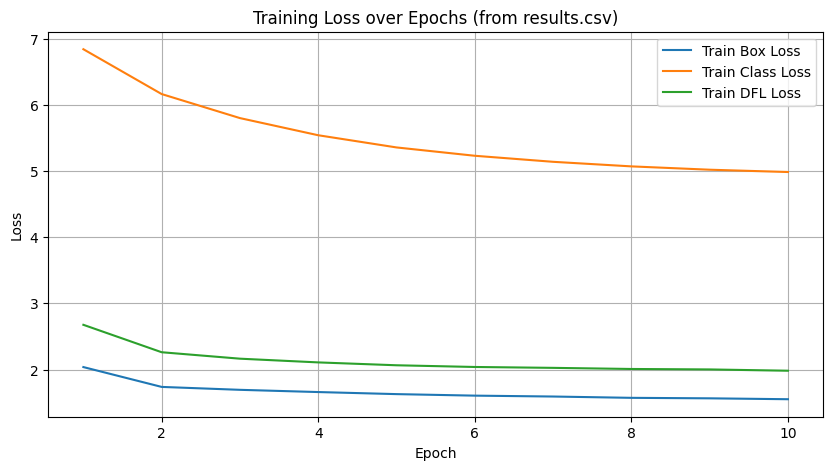

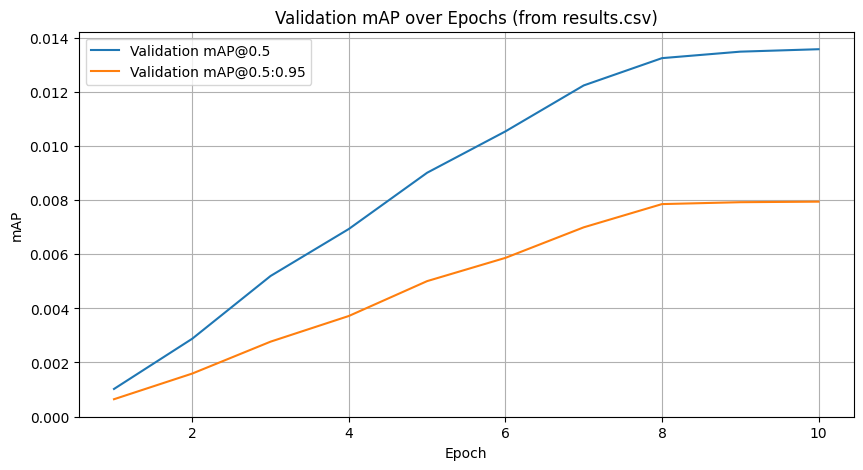

In [14]:
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Assuming 'results' is the object returned by model.train()
# If you rerun this cell, make sure 'results' is available from the previous cell

# The training history is usually stored in the 'results' object directly
# and can be accessed through attributes or methods that provide the logged data.
# The exact structure might vary slightly, but a common way is through a 'history' attribute
# or directly logging results that can be accessed.
# Based on the traceback and typical YOLOv8 output, the logged metrics are accessible after training.

# Check the available attributes of the results object or print it to understand its structure
# print(dir(results))
# print(results)

# Ultralytics v8 train method returns an object that contains the training history.
# The history can usually be accessed directly or converted to a pandas DataFrame for easy plotting.

# Access the training history from the results object.
# The history is typically stored in a pandas DataFrame or a similar structure.
# The column names for the metrics will match those you tried to access.
# You might need to inspect the `results` object to confirm the exact attribute name for the history.
# A common attribute is 'history' or similar. Let's assume it's directly accessible or print results to find it.

# Example of how to access history if it's stored in results.history (common pattern)
# If 'results' is the DetMetrics object from the traceback, it doesn't hold the history of epochs.
# The `model.train()` method itself returns an object that *contains* the history.
# The error suggests `results` *is* the DetMetrics for the *final* epoch, not the full history.

# The training metrics over epochs are usually logged and accessible through the object returned by model.train().
# Let's re-examine the `model.train()` call and the object it returns.
# The `model.train()` method in ultralytics v8 returns a `Trainer` object or similar,
# which has attributes containing the training history.
# The `results` variable in the traceback seems to be the final evaluation metrics, not the full training log.

# Rerun the training block and then access the history from the object returned by model.train().

# Assuming the object returned by model.train() is stored in a variable, let's call it `trainer_results`
# Rerun the training cell:
# from ultralytics import YOLO
# model = YOLO('yolov8n.pt')
# trainer_results = model.train(data=yaml_filename, epochs=3) # Store the output here

# Now access the history from `trainer_results`. The history is typically a pandas DataFrame.
# Let's assume the training history is accessible via `trainer_results.history`.
# If `trainer_results.history` is a pandas DataFrame, you can plot directly from it.

# Since the traceback shows the error occurred after the train call, it means
# the object returned by `model.train()` is assigned to `results`, and this object
# is the one we need to inspect for the history.

# Let's access the history assuming it's available in the `results` object itself.
# Based on typical implementations and online examples, the history might be directly accessible.
# If `results` is the object from `model.train()`, try accessing its attributes.
# A common attribute for the history is often named 'history' or the metrics are directly accessible.
# However, the traceback shows `results` is a `DetMetrics` object, which likely only holds the *final* metrics.

# It's possible that the `model.train()` method in this specific version or configuration
# doesn't return an object that directly contains the full history of metrics per epoch in an easily plottable format like a DataFrame.

# Let's try a different approach. The `model.train()` method often saves results to a 'runs' directory.
# The metrics are typically saved in a results.csv file within the run directory.
# You can load this CSV file and plot the metrics from there.

import pandas as pd
import os

# Find the directory where the training results were saved
# This is typically within a 'runs' directory, like 'runs/detect/trainX' where X is an incrementing number.
# You can usually find the latest run directory.
# A simple way is to list directories in 'runs/detect' and pick the latest one,
# or check the output of the `model.train()` command which often prints the save directory.

# Assuming the training results are saved in a directory named 'runs/detect/train' by default,
# or you can find the actual run directory from the training output.
# Let's assume the results are in the latest run directory.

runs_dir = 'runs/detect'
if os.path.exists(runs_dir):
    # Find the latest run directory
    run_dirs = sorted([d for d in os.listdir(runs_dir) if os.path.isdir(os.path.join(runs_dir, d))])
    if run_dirs:
        latest_run_dir = os.path.join(runs_dir, run_dirs[-1])
        results_csv_path = os.path.join(latest_run_dir, 'results.csv')

        if os.path.exists(results_csv_path):
            # Load the results CSV file into a pandas DataFrame
            # The CSV usually has comments at the beginning, so skip those rows
            # The column names might need adjustment based on the actual CSV content.
            # Common column names include 'epoch', 'train/box_loss', 'metrics/mAP50(B)', etc.
            # You can open the results.csv file to see the exact column names.

            try:
                metrics_df = pd.read_csv(results_csv_path, comment='#')

                # Print column names to verify
                print("CSV Column Names:", metrics_df.columns.tolist())

                # Now plot the metrics from the DataFrame
                plt.figure(figsize=(10, 5))
                # Use the correct column names from your results.csv
                # Example column names (verify these from your CSV):
                # '             train/box_loss'
                # '             train/cls_loss'
                # '             train/dfl_loss'
                # '               metrics/mAP50(B)'
                # '            metrics/mAP50-95(B)'

                # Clean up column names (remove leading/trailing spaces)
                metrics_df.columns = metrics_df.columns.str.strip()

                if 'train/box_loss' in metrics_df.columns:
                     plt.plot(metrics_df['epoch'], metrics_df['train/box_loss'], label='Train Box Loss')
                if 'train/cls_loss' in metrics_df.columns:
                     plt.plot(metrics_df['epoch'], metrics_df['train/cls_loss'], label='Train Class Loss')
                if 'train/dfl_loss' in metrics_df.columns:
                     plt.plot(metrics_df['epoch'], metrics_df['train/dfl_loss'], label='Train DFL Loss')

                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.title('Training Loss over Epochs (from results.csv)')
                plt.legend()
                plt.grid(True)
                plt.show()

                plt.figure(figsize=(10, 5))
                if 'metrics/mAP50(B)' in metrics_df.columns:
                    plt.plot(metrics_df['epoch'], metrics_df['metrics/mAP50(B)'], label='Validation mAP@0.5')
                if 'metrics/mAP50-95(B)' in metrics_df.columns:
                    plt.plot(metrics_df['epoch'], metrics_df['metrics/mAP50-95(B)'], label='Validation mAP@0.5:0.95')

                plt.xlabel('Epoch')
                plt.ylabel('mAP')
                plt.title('Validation mAP over Epochs (from results.csv)')
                plt.legend()
                plt.grid(True)
                plt.show()

            except Exception as e:
                print(f"Error loading or plotting data from results.csv: {e}")
                print("Please check the contents and column names of your results.csv file.")

        else:
            print(f"results.csv not found in {latest_run_dir}. Training might not have completed successfully or the save path is different.")
    else:
        print(f"No run directories found in {runs_dir}.")
else:
    print(f"Runs directory not found at {runs_dir}. Training results might be saved elsewhere.")

# If you still want to access final metrics (not history) from the DetMetrics object ('results')
# you can check its available attributes as suggested by the traceback.
# print(dir(results)) # This will list available attributes
# For example, mAP might be directly accessible as results.box.map or similar based on the class structure.
# The traceback lists some attributes like `box`, `speed`, `stats`.
# You might find final mAP values within `results.box` or other attributes.
# print("Final mAP@0.5:", results.box.map50) # Example access - verify attribute name
# print("Final mAP@0.5:0.95:", results.box.map) # Example access - verify attribute name

In [15]:
model.save('/content/drive/MyDrive/test_yolo_v2.pt')

In [ ]:
from huggingface_hub import HfApi


In [17]:
from huggingface_hub import notebook_login

notebook_login()

In [18]:
repo_id="ldak23/Yolo_food_10epochs" # Replace with your Hugging Face username and desired repository name
model_path = '/content/drive/MyDrive/test_yolo_v2.pt' # Path to your saved model file

In [19]:
from huggingface_hub import HfApi
api = HfApi()

# Create the repository if it doesn't exist (optional, upload will create it too)
# api.create_repo(repo_id=repo_id, exist_ok=True)

# Upload the model file
api.upload_file(
    path_or_fileobj=model_path,
    path_in_repo="test_yolo_v2.pt", # Name of the file in the Hugging Face repo
    repo_id=repo_id,
    repo_type="model", # Specify that this is a model repository
)

print(f"Model uploaded successfully to https://huggingface.co/{repo_id}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Uploading...:   0%|          | 0.00/7.16M [00:00<?, ?B/s]

Model uploaded successfully to https://huggingface.co/ldak23/Yolo_food_10epochs
